# Notebook to look at first multichannel recordings

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import glob
import pickle
# import pywt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import find_peaks, hilbert, peak_widths
from scipy.spatial.distance import cdist
from scipy.stats import median_abs_deviation

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from neo.io import Spike2IO

# from matplotlib import rcParams
from mosquito.process_abf import (load_processed_data, cluster_spikes, save_processed_data, detect_spikes, estimate_spike_rate, 
                                   detrend_emg, filter_emg)
from mosquito.util import set_plot_params, my_adjust_axes, my_add_scalebar, idx_by_thresh
from mosquito.get_wing_kinematics import load_video_data, fetch_benifly_data, align_kinematics_to_cam


## Params

In [3]:
plt.style.use('dark_background')
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize for x tick labels
plt.rc('ytick', labelsize=14)    # fontsize for y tick labels

plot_type = 'poster'  # 'paper' or 'powerpoint' or 'poster
plot_params = set_plot_params(plot_type=plot_type)

## Helper functions


In [4]:
def plot_spike_raster(spike_times_list, ax=None, xlim=None,colors=['k', 'k', 'k', 'k'], labels=None):
    """
    Given a list containing multiple arrays of spike times, plot the spike times as a raster

    """
    # make sure we have an axis object
    if ax is None:
        fig, ax = plt.subplots()

    # get extent of raster lines on y-axis 
    line_boundaries = np.linspace(0, 1, len(spike_times_all) + 1)
    boundary_ctrs = (line_boundaries[:-1] + line_boundaries[1:])/2.0


    # loop over spike time lists
    for ith, spike_times in enumerate(spike_times_list):
        # current boundaries for raster lines
        ymin = line_boundaries[ith+1]
        ymax = line_boundaries[ith]

        spike_times_curr = spike_times.copy()
        if xlim is not None:
            spike_times_curr =  spike_times_curr[(spike_times_curr >= xlim[0]) & (spike_times_curr <= xlim[1])]
       
            
        # loop over spikes
        for st in spike_times:
            ax.axvline(st, ymin=ymin, ymax=ymax, color=colors[ith])

    # set labels if we have them
    if labels is not None:
        ax.set_yticks(boundary_ctrs, labels=labels)

    # set x (time) limits if we have them
    if xlim is not None:
        ax.set_xlim(xlim)
        
    return ax
    

## Load data

In [5]:
# file info
data_folder = 57
axo_num = 0

data = load_processed_data(data_folder, axo_num)


In [131]:
# read out data
emg = data['emg']
emg_filt = data['emg_filt']
t = data['time']
spike_t = data['spike_t']

fs = data['sampling_freq']

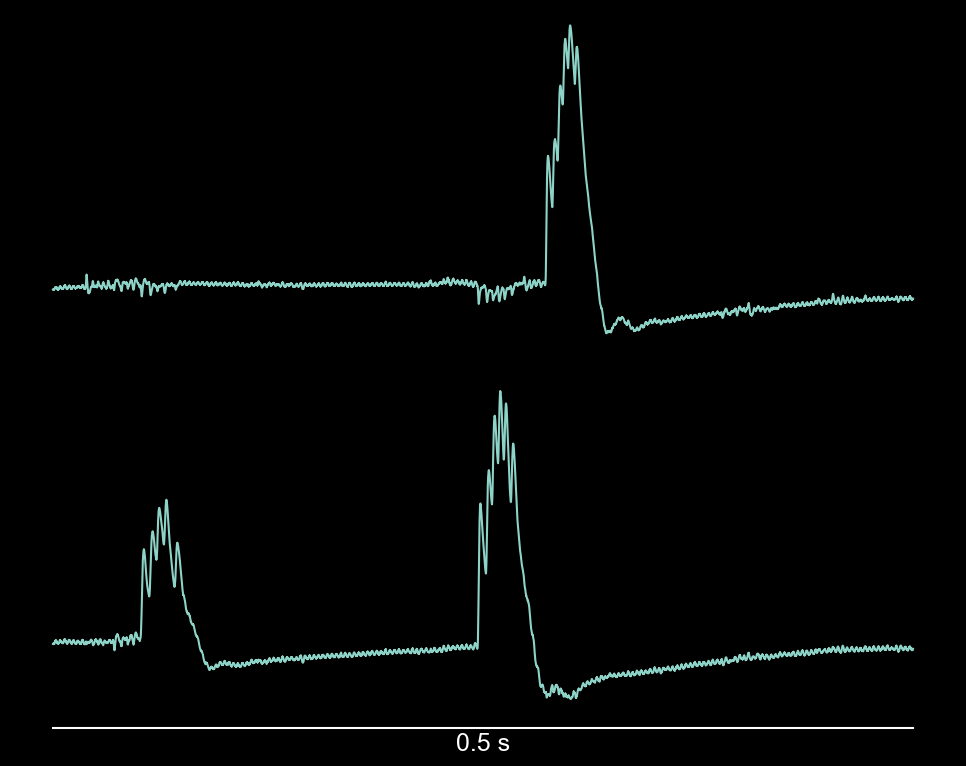

In [135]:
# quick viz
fig, ax_list = plt.subplots(len(emg_filt), 1, figsize=(10,8))
ax_list = ax_list.ravel()

tmin = 5.5  #0
tmax = 6 # 0.2  # 2
tmask = (t >= tmin) & (t <= tmax)

for ith, ef in enumerate(emg):
    ax_list[ith].plot(t[tmask] - t[tmask][0], ef[tmask])
    if ith == 1:
        ax_list[ith] = my_adjust_axes(ax_list[ith], keep_spines=['bottom'])
    else:
        ax_list[ith] = my_adjust_axes(ax_list[ith], keep_spines=['none'])

my_add_scalebar(ax_list[ith], scalebar_bounds=[0, 0.5], units='s')

fig.tight_layout()
# save_path = '/media/sam/SamData/Dropbox/Misc Presentations/Dickinson Group Meeting 10-23-2024/ifm_recordings/multi_channel_trace.png'
# fig.savefig(save_path)

# # ax_twin = ax.twinx()
# ax.plot(t[tmask], emg_filt[1][tmask], color='orange', alpha=0.5)

# ax.set_xlim([0, 2])

## Issue #1: signal amplitude drift
This makes reliable spike clustering difficult. Want a way to standardize the amplitude

Seems like we *can* make heights of spike peaks more separable, but it's unclear how much that actually benefits us.

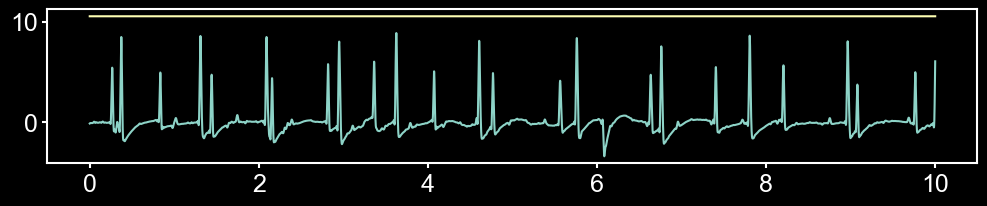

In [8]:
# as a first pass, let's try the method we use for getting the envelope from mic data
emg1 = emg_filt[1]

# get envelope of signal from hilbert trans
analytic_emg1 = hilbert(emg1)
emg1_envelope = np.abs(analytic_emg1)

# take rolling max of envelope and filter it
rolling_window = round(50*fs)
envelope_series = pd.Series(emg1_envelope)
envelope_filt = envelope_series.rolling(window=rolling_window,
                                        center=True).max()
envelope_filt = envelope_filt.rolling(window=rolling_window,
                                      center=True).mean()

# fill nan values
envelope_filt.ffill(inplace=True)
envelope_filt.bfill(inplace=True)

# visualize
fig, ax = plt.subplots(figsize=(12, 2))

tmin = 0 #0
tmax = 10  # 0.2  # 2
tmask = (t >= tmin) & (t <= tmax)

ax.plot(t[tmask], emg1[tmask])
ax.plot(t[tmask], envelope_filt[tmask])

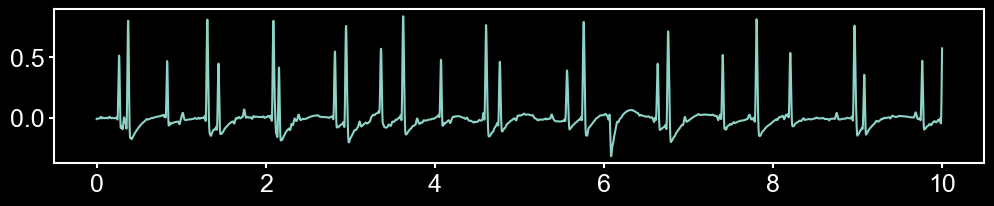

In [9]:
# that's actually not too bad. what does it look like if we now renormalize
emg1_renorm = emg1 / envelope_filt

# visualize
fig, ax = plt.subplots(figsize=(12, 2))

tmin = 0 #0
tmax = 10  # 0.2  # 2
tmask = (t >= tmin) & (t <= tmax)

ax.plot(t[tmask], emg1_renorm[tmask])


In [10]:
# try spike detection with re-normalized emg signal
params = data['params']
spikes, spike_t, spike_idx = detect_spikes(emg1_renorm, fs,   #
                                           window=params['emg_window'],
                                           offset=params['emg_offset'],
                                           min_spike_dt=params['min_spike_dt'],
                                           thresh_factors=params['thresh_factors'],
                                           recenter_window_factor=0.1,
                                           detrend_window=int(4 * params['emg_window']),
                                           abs_flag=False,
                                           detrend_flag=True,
                                           remove_edge_case_flag=False,
                                           viz_flag=False)


For n_clusters = 2 The average silhouette_score is : 0.43233172656229746
For n_clusters = 3 The average silhouette_score is : 0.4625079534875449
For n_clusters = 4 The average silhouette_score is : 0.4714678779060646
For n_clusters = 5 The average silhouette_score is : 0.5159028479629737
For n_clusters = 6 The average silhouette_score is : 0.5238277845206235
For n_clusters = 7 The average silhouette_score is : 0.49391196058656406
For n_clusters = 8 The average silhouette_score is : 0.48415779304640433


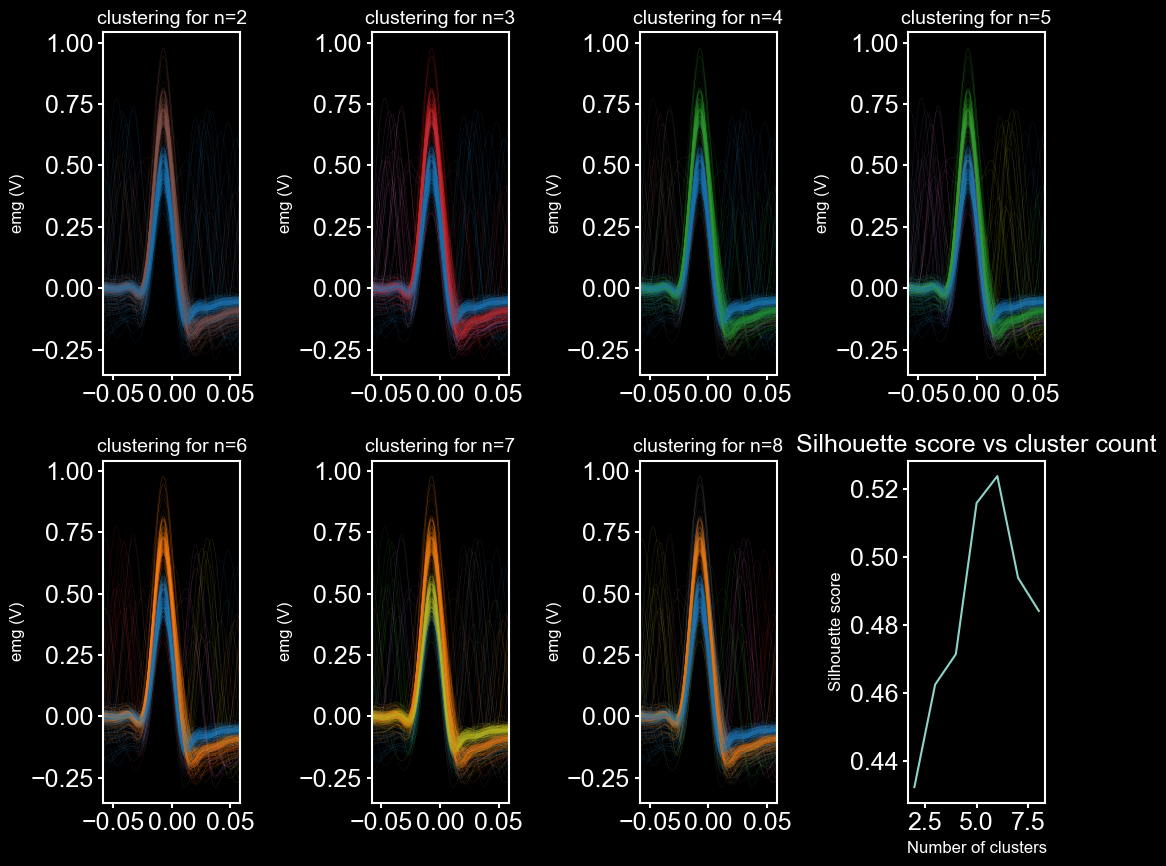

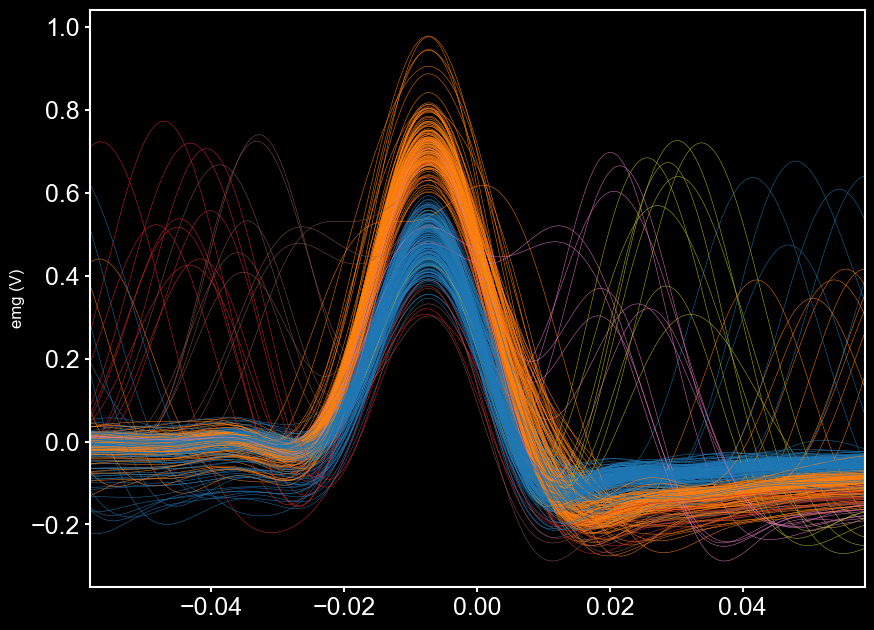

In [11]:
# try spike clustering with re-normalized emg signal
cluster_labels, cluster_dict = cluster_spikes(spikes,
                                              spike_t=spike_t,
                                              save_path=None,
                                              viz_flag=True)

In [12]:
# data['cluster_dict'] = cluster_dict
# data['spike_idx'] = spike_idx

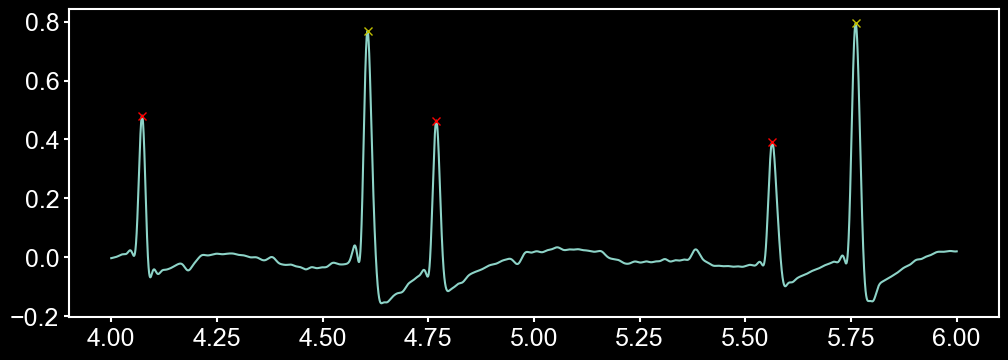

In [13]:
# look at assigned clusters
fig, ax = plt.subplots(figsize=(12,4))

cluster_labels = cluster_dict[2]

tmin = 4 #0
tmax = 6 # 0.2  # 2
tmask = (t >= tmin) & (t <= tmax)

ax.plot(t[tmask], emg1_renorm[tmask])

colors = ['r', 'y']
for ith, cval in enumerate(np.unique(cluster_labels)):
    idx = spike_idx[cluster_labels == cval]
    tmask_spikes = (t[idx] >= tmin) & (t[idx] <= tmax)
    
    ax.plot(t[idx][tmask_spikes], emg1_renorm[idx][tmask_spikes], 'x', color=colors[ith])


In [15]:
# # look at the distribution of peak heights for renormalized and normal data
# fig, (ax0, ax1) = plt.subplots(2,1)

# # normal data
# for cval in np.unique(data['cluster_dict'][2]):
#     cidx = (data['cluster_dict'][2] == cval)
#     ax0.hist(emg1[data['spike_idx'][cidx]], density=True)

# # re-normed data
# for cval in np.unique(cluster_dict[2]):
#     cidx = (cluster_dict[2] == cval)
#     ax1.hist(emg1_renorm[spike_idx[cidx]], density=True)

/tmp/ipykernel_387551/732844094.py:4: PeakPropertyWarning: some peaks have a prominence of 0
  peak_widths_renorm = peak_widths(emg1_renorm, spike_idx)
/tmp/ipykernel_387551/732844094.py:4: PeakPropertyWarning: some peaks have a width of 0
  peak_widths_renorm = peak_widths(emg1_renorm, spike_idx)


(array([158.,   0.,   0., ...,   0.,   0.,   2.]),
 array([   0.    ,   74.7471,  149.4942, ..., 1345.4478, 1420.1949,
        1494.942 ]),
 <BarContainer object of 20 artists>)

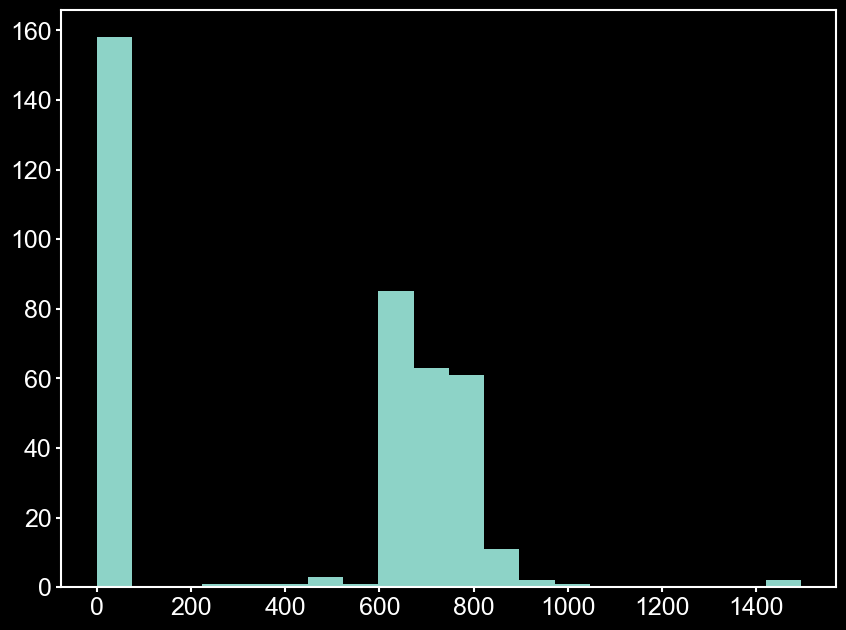

In [16]:
# get peak heights and widths in renormalized data
mean_peak_heights_renorm = np.asarray([np.max(np.mean(spikes[cluster_dict[2] == cval], axis=0)) for cval in np.unique(cluster_dict[2])])
peak_heights_renorm = emg1_renorm[spike_idx]
peak_widths_renorm = peak_widths(emg1_renorm, spike_idx)

plt.hist(peak_widths_renorm[0], bins=20)
# plt.hist(peak_heights_renorm, bins=20)
# plt.axvline(mean_peak_heights_renorm[0])
# plt.axvline(mean_peak_heights_renorm[1])

[  13085  103512  167326 ... 6919177 6963621 7088927]


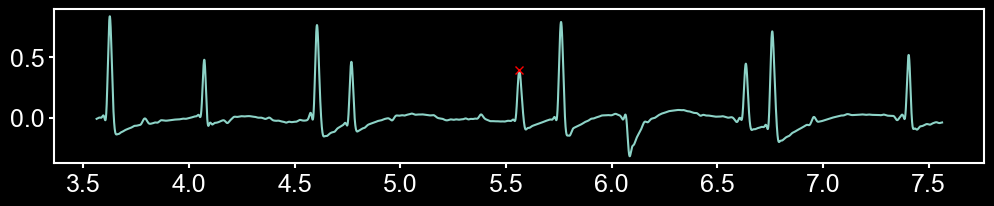

In [17]:
# where do we find extra wide peaks?
wide_spike_idx = spike_idx[(peak_widths_renorm[0] < 200)]
print(wide_spike_idx)

ex_ind = 3

# visualize
fig, ax = plt.subplots(figsize=(12, 2))

tmin = t[wide_spike_idx[ex_ind]] - 2 #0
tmax = t[wide_spike_idx[ex_ind]] + 2  # 0.2  # 2
tmask = (t >= tmin) & (t <= tmax)

ax.plot(t[tmask], emg1_renorm[tmask])
ax.plot(t[wide_spike_idx[ex_ind]], emg1_renorm[wide_spike_idx[ex_ind]], 'rx')

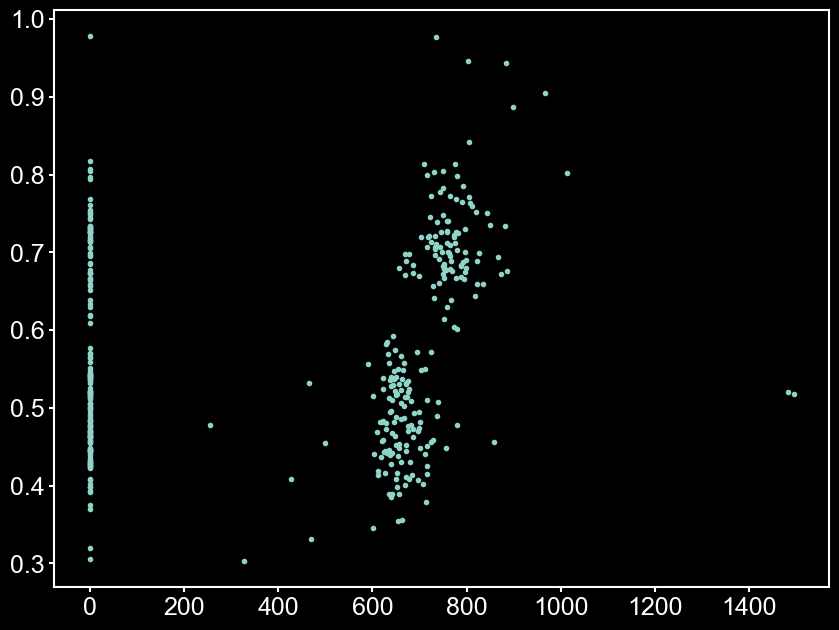

In [18]:
plt.plot(peak_widths_renorm[0], peak_heights_renorm, '.')

In [19]:
# try recluster peak heights
# means_init = np.concatenate((mean_peak_heights_renorm, np.array([0.7*np.sum(mean_peak_heights_renorm)]))).reshape(-1, 1)
means_init = mean_peak_heights_renorm.reshape(-1, 1)

print(means_init)
gm = GaussianMixture(n_components=2, random_state=47, means_init=means_init)
new_labels = gm.fit_predict(peak_heights_renorm.values.reshape(-1, 1))
print(gm.means_)
scores = gm.score_samples(peak_heights_renorm.values.reshape(-1, 1))

[[0.4786]
 [0.7139]]
[[0.4766]
 [0.7153]]


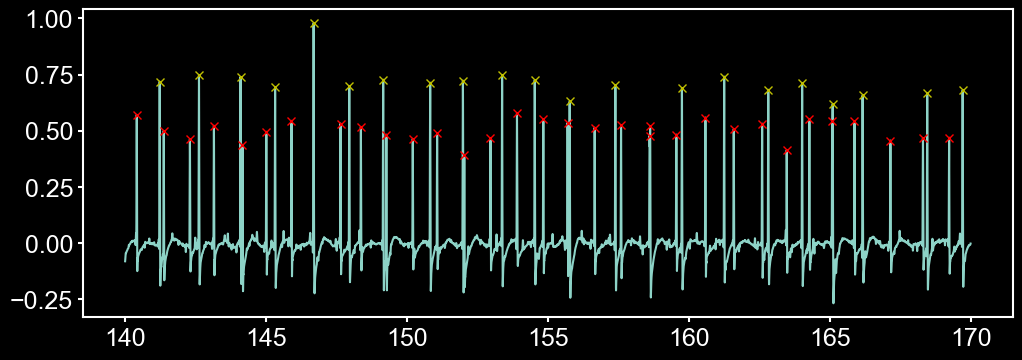

In [20]:
fig, ax = plt.subplots(figsize=(12,4))

cluster_labels = new_labels.copy()
# [ 38.4363  41.6866  59.4638  91.3093 105.5291 146.6874]
tmin = 140 #0
tmax = 170  # 0.2  # 2
tmask = (t >= tmin) & (t <= tmax)

ax.plot(t[tmask], emg1_renorm[tmask])

colors = ['r', 'y', 'g']
for ith, cval in enumerate(np.unique(cluster_labels)):
    idx = spike_idx[cluster_labels == cval]
    tmask_spikes = (t[idx] >= tmin) & (t[idx] <= tmax)
    
    ax.plot(t[idx][tmask_spikes], emg1_renorm[idx][tmask_spikes], 'x', color=colors[ith])

[ 38.4363  41.6866  59.4638  91.3093 105.5291 146.6874]


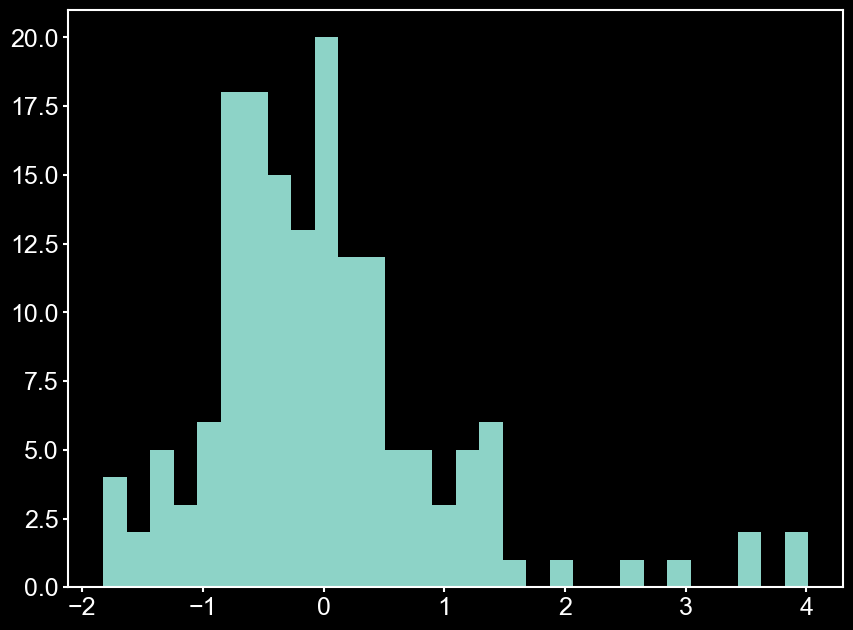

In [21]:
# try to pull out the merged/extra-high peaks 
highest_peak_ind = np.argmax(gm.means_)
highest_peak_heights = peak_heights_renorm[new_labels == highest_peak_ind]
highest_peak_heights_z = (highest_peak_heights - np.mean(highest_peak_heights))/np.std(highest_peak_heights)

# find outliers among the peaks of the otherwise largest spiking unit
plt.hist(highest_peak_heights_z, bins=30)

outlier_idx = spike_idx[new_labels == highest_peak_ind][np.abs(highest_peak_heights_z) >= 2]
print(t[outlier_idx])

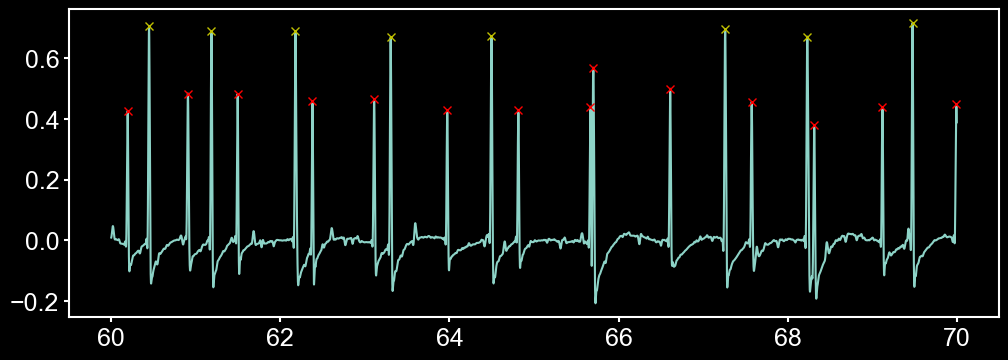

In [128]:
# visualize after we try removing additive peaks
fig, ax = plt.subplots(figsize=(12,4))

cluster_labels = new_labels.copy()
tmp = np.where(new_labels == highest_peak_ind)[0]
tmp2 = tmp[np.abs(highest_peak_heights_z) >= 2.0]
# cluster_labels[new_labels == highest_peak_ind][np.abs(highest_peak_heights_z) >= 2] += 1
cluster_labels[tmp2] = np.max(cluster_labels) + 1

tmin = 60 #0
tmax = 70  # 0.2  # 2
tmask = (t >= tmin) & (t <= tmax)

ax.plot(t[tmask], emg1_renorm[tmask])

colors = ['r', 'y', 'g']
for ith, cval in enumerate(np.unique(cluster_labels)):
    idx = spike_idx[cluster_labels == cval]
    tmask_spikes = (t[idx] >= tmin) & (t[idx] <= tmax)
    
    ax.plot(t[idx][tmask_spikes], emg1_renorm[idx][tmask_spikes], 'x', color=colors[ith])

(60.0, 70.0)

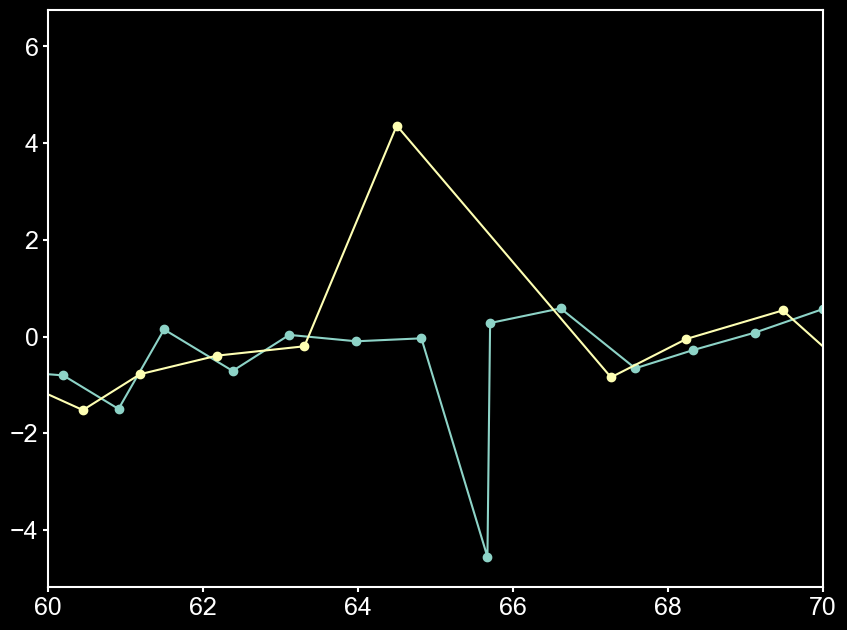

In [129]:
# we're still not getting exact labels. maybe one spike per trial is an acceptable error, but can we do better using temporal info
isis = list()  # the inter-spike intervals
isis_z = list()  # the z-scored inter-spike intervals
isis_t = list()  # the times at which we're evaluating the inter-spike intervals
# cluster_labels = new_labels

for cval in np.unique(cluster_labels)[:-1]:
    curr_idx = (cluster_labels == cval) | (cluster_labels == np.max(cluster_labels))
    isi = np.diff(t[spike_idx][curr_idx])
    isi_z = (isi - np.mean(isi))/np.std(isi)
    
    plt.plot(t[spike_idx][curr_idx][:-1], isi_z, 'o-')
    # plt.plot(isi_z, 'o-')
    
    isis.append(isi)
    isis_z.append(isi_z)
    isis_t.append(t[spike_idx][curr_idx][:-1])


plt.xlim([60, 70])

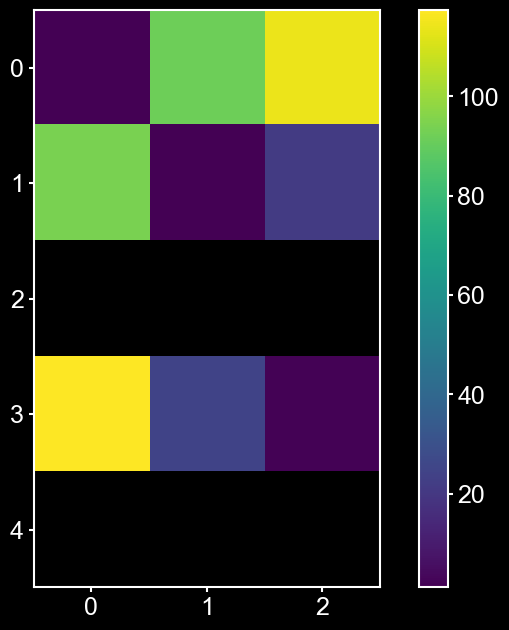

In [90]:
# use extreme points in the ISI values to find possible switch points
extreme_isi_idx = [(np.abs(isi_z) > 3) for isi_z in isis_z]
extreme_isi_t = [isi_t[idx] for isi_t, idx in zip(isis_t, extreme_isi_idx)]

dist = np.abs(np.subtract.outer(extreme_isi_t[0], extreme_isi_t[1]))
sign_mat = np.outer(np.sign(isis_z[0][extreme_isi_idx[0]]), np.sign(isis_z[1][extreme_isi_idx[1]]))
dist[sign_mat > 0] = np.inf

plt.imshow(dist, interpolation='none')
#plt.imshow(sign_mat, interpolation='none')
plt.colorbar()

In [115]:
# from the above, we should be able to get locations for potential swaps
extreme_isis_where = [np.where(e_isi)[0] for e_isi in extreme_isi_idx]
extreme_t_diff_thresh = 3.0

potential_swap_ind = []

# to pull out potential swap points, we need to identify pairs of these extreme ISIs wi
if dist.shape[1] <= dist.shape[0]:
    for col in range(dist.shape[1]):
        min_val = np.min(dist[:,col])
        if min_val < extreme_t_diff_thresh:
            min_ind = np.argmin(dist[:,col])
            potential_swap_ind.append([min_ind, col])
else:
    for row in range(dist.shape[0]):
        min_val = np.min(dist[row, :])
        if min_val < extreme_t_diff_thresh:
            min_ind = np.argmin(dist[row,:])
            potential_swap_ind.append([row, min_ind])

# it's most useful to have the swap indices in terms of the cluster_labels indices

print(potential_swap_ind)
potential_swap_ind_spike_idx = []
for swap_ind in potential_swap_ind:
    new_swap_ind = []
    for cval in [0, 1]:
        curr_idx = np.where((cluster_labels == cval) | (cluster_labels == np.max(cluster_labels)))[0]
        print(curr_idx[:-1][extreme_isi_idx[cval]][swap_ind[cval]])
        new_swap_ind.append(curr_idx[:-1][extreme_isi_idx[cval]][swap_ind[cval]])
    potential_swap_ind_spike_idx.append(new_swap_ind)
print(potential_swap_ind_spike_idx)

[[0, 0], [1, 1], [3, 2]]
142
140
315
313
354
352
[[142, 140], [315, 313], [354, 352]]


[112.52116005688764, 81.10958084128168]
[142, 140]
[115.14444071284541, 83.33502699319382]


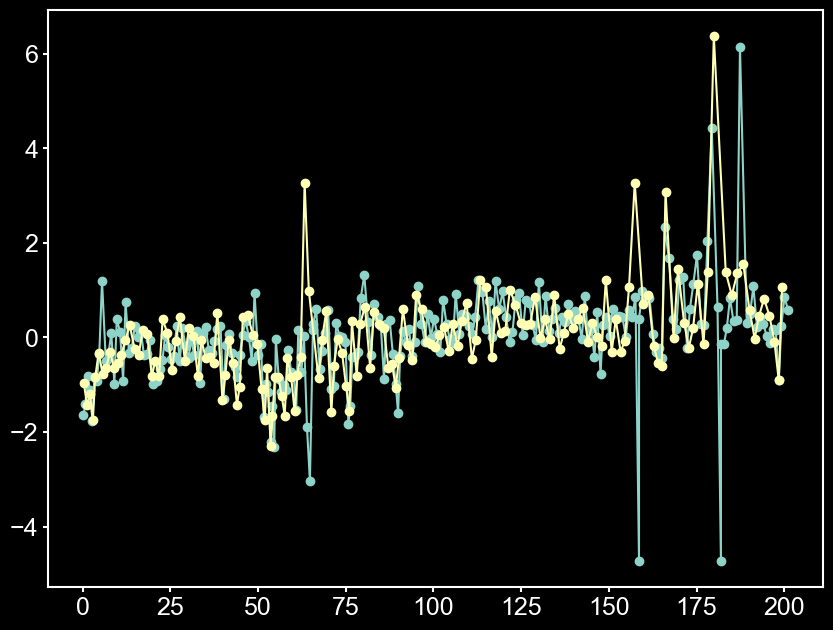

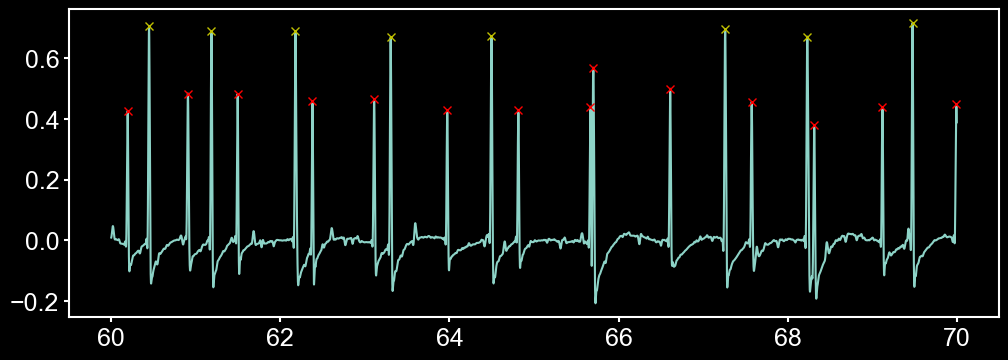

In [130]:
# now we can test each potential swap -- if the overall "chi^2" (distance to rolling median signal) is decreased, do i
isi_z_dfs = [pd.Series(isi_z) for isi_z in isis_z]
isi_rolling_medians = [] 
for df in isi_z_dfs:
    roll_med_df = df.rolling(window=10, center=True).median()
    roll_med_df.ffill(inplace=True)
    roll_med_df.bfill(inplace=True)
    isi_rolling_medians.append(roll_med_df.values)
    
unswapped_distances = [np.sum(np.sqrt((isi_z - isi_roll_med)**2)) for isi_z, isi_roll_med in zip(isis_z, isi_rolling_medians)]
print(unswapped_distances)

# loop over possible swaps
swaps_to_do = list()
for swap_ind in potential_swap_ind_spike_idx:
    # generate cluster labels with the swap
    print(swap_ind)
    swapped_cluster_labels = cluster_labels.copy()
    swapped_cluster_labels[swap_ind[0]] = cluster_labels[swap_ind[1]]
    swapped_cluster_labels[swap_ind[1]] = cluster_labels[swap_ind[0]]
    
    # recalculcate ISIs
    isis_swapped_z = []
    for cval in np.unique(swapped_cluster_labels)[:-1]:
        curr_idx = (swapped_cluster_labels == cval) | (swapped_cluster_labels == np.max(cluster_labels))
        isi = np.diff(t[spike_idx][curr_idx])
        isi_z = (isi - np.mean(isi))/np.std(isi)
        
        plt.plot(isis_t[cval], isi_z, 'o-')
        isis_swapped_z.append(isi_z)
        
    # get distances to rolling median signals
    swapped_distances = [np.sum(np.sqrt((isi_z - isi_roll_med)**2)) for isi_z, isi_roll_med in zip(isis_swapped_z, isi_rolling_medians)]
    print(swapped_distances)
    break

# plot
fig, ax = plt.subplots(figsize=(12,4))

tmin = 60 #0
tmax = 70  # 0.2  # 2
tmask = (t >= tmin) & (t <= tmax)

ax.plot(t[tmask], emg1_renorm[tmask])

colors = ['r', 'y', 'g']
for ith, cval in enumerate(np.unique(swapped_cluster_labels)):
    idx = spike_idx[cluster_labels == cval]
    tmask_spikes = (t[idx] >= tmin) & (t[idx] <= tmax)
    
    ax.plot(t[idx][tmask_spikes], emg1_renorm[idx][tmask_spikes], 'x', color=colors[ith])

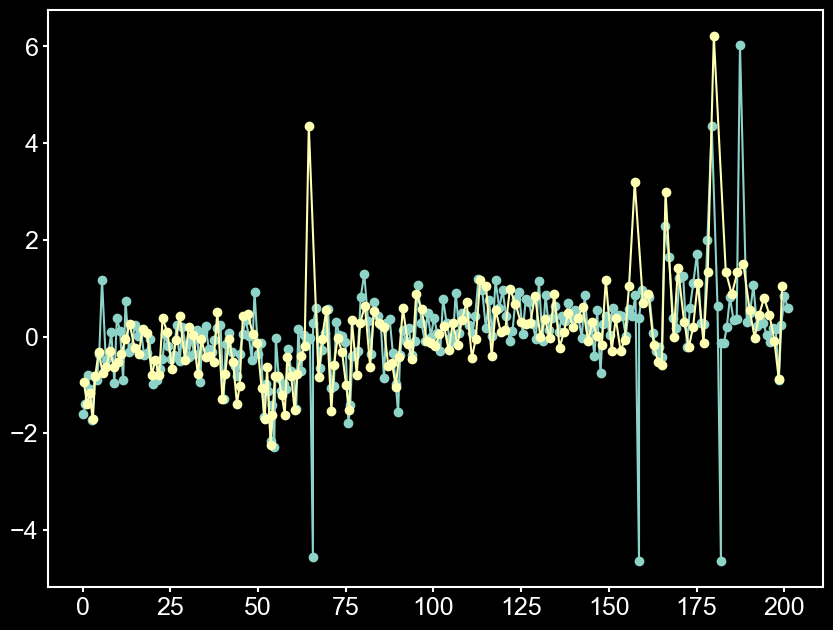

In [127]:
for isi_t, isi_z in zip(isis_t, isis_z):
    plt.plot(isi_t, isi_z, 'o-')

In [100]:
swap_ind

[3, 2]

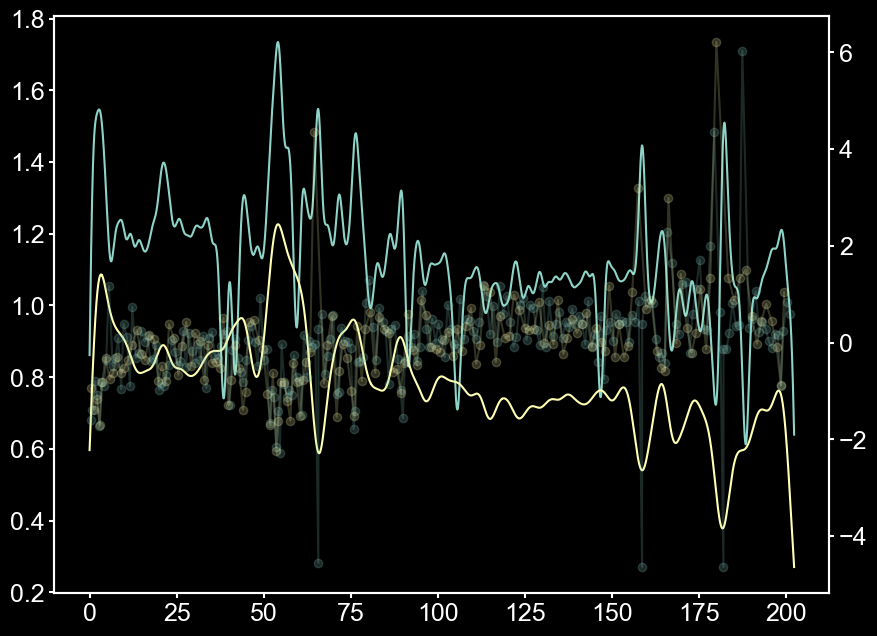

In [144]:
spike_rate_list = []
cluster_labels = new_labels.copy()
fig, ax = plt.subplots()
for ith, cval in enumerate(np.unique(cluster_labels)):
    idx = spike_idx[cluster_labels == cval]
    sp_rate = estimate_spike_rate(idx, fs, t.size)
    ax.plot(t, sp_rate)
    spike_rate_list.append(sp_rate)

ax1 = ax.twinx()
for isi_t, isi_z in zip(isis_t, isis_z):
    ax1.plot(isi_t, isi_z, 'o-', alpha=0.2)

[ 12.2694  14.8827  38.4363 ... 105.5291 146.6874 198.4673]


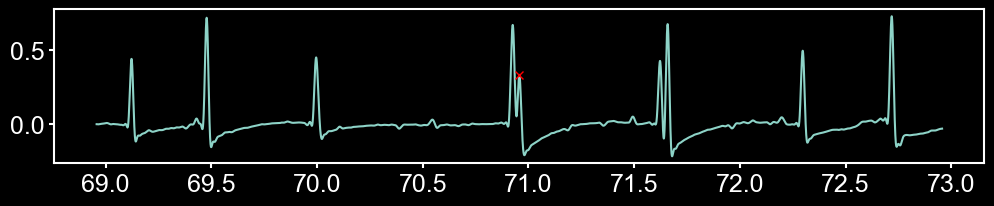

In [155]:
# which spikes have low log-likelihood scores?
low_score_spike_idx = spike_idx[scores <= -1]
print(t[low_score_spike_idx])
ex_ind = 6

# visualize
fig, ax = plt.subplots(figsize=(12, 2))

tmin = t[low_score_spike_idx[ex_ind]] - 2 #0
tmax = t[low_score_spike_idx[ex_ind]] + 2  # 0.2  # 2
tmask = (t >= tmin) & (t <= tmax)

ax.plot(t[tmask], emg1_renorm[tmask])
ax.plot(t[low_score_spike_idx[ex_ind]], emg1_renorm[low_score_spike_idx[ex_ind]], 'rx')

## Issue #2: spike clustering can still give varied results
Want to more reliably identify different units. Use STUMPY? Also need a solution for when units overlap and give large additive peak.

Okay, seems like stumpy is actually best for z-scored sequences, but i care about amplitude here...

For n_clusters = 2 The average silhouette_score is : 0.5727347792039943
For n_clusters = 3 The average silhouette_score is : 0.5963063114620253
For n_clusters = 4 The average silhouette_score is : 0.6089887978149715
For n_clusters = 5 The average silhouette_score is : 0.5132836381571025
For n_clusters = 6 The average silhouette_score is : 0.4193217431239549
For n_clusters = 7 The average silhouette_score is : 0.3562519775604125
For n_clusters = 8 The average silhouette_score is : 0.5312156856745694
For n_clusters = 2 The average silhouette_score is : 0.3992577476422547
For n_clusters = 3 The average silhouette_score is : 0.30233062016533263
For n_clusters = 4 The average silhouette_score is : 0.3551459382344445
For n_clusters = 5 The average silhouette_score is : 0.3854998995133182
For n_clusters = 6 The average silhouette_score is : 0.39240814775612787
For n_clusters = 7 The average silhouette_score is : 0.41155599415081096
For n_clusters = 8 The average silhouette_score is : 0.361941

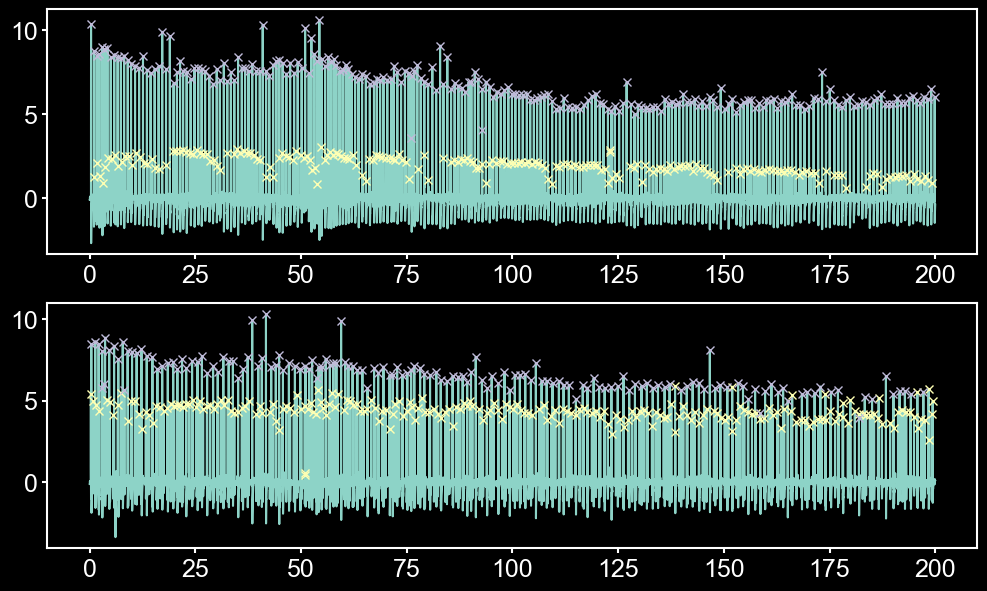

In [10]:
# get each unit individually
spike_idx = data['spike_idx']
cluster_labels_all = []
cluster_dicts = []

fig, ax_list = plt.subplots(len(emg_filt), 1, figsize=(12,7))
ax_list = ax_list.ravel()

tmin = 0 #0
tmax = 200  # 0.2  # 2
tmask = (t >= tmin) & (t <= tmax)

for ith, ef in enumerate(emg_filt):
    ax_list[ith].plot(t[tmask], ef[tmask])

    # recluster values
    _, cluster_dict = cluster_spikes(data['spikes'][ith],
                                      spike_t=data['spike_t'][ith],
                                      save_path=None,
                                      viz_flag=False)

    # take 2-cluster outcome
    cluster_labels = cluster_dict[2]

    # store clustering results
    cluster_labels_all.append(cluster_labels)
    cluster_dicts.append(cluster_dict)

    # visualize
    for cval in np.unique(cluster_labels):
        idx = spike_idx[ith][cluster_labels == cval]
        tmask_spikes = (t[idx] >= tmin) & (t[idx] <= tmax)
        ax_list[ith].plot(t[idx][tmask_spikes], ef[idx][tmask_spikes], 'x')
    

In [11]:
# get the mean of each spike cluster (to use with pattern matching)
cluster_means_all = []
for ith, cluster_labels in enumerate(cluster_labels_all):
    cluster_means = []
    # spike_idx_curr = data['spike_idx'][ith]
    spikes_curr = data['spikes'][ith]
    
    for cval in np.unique(cluster_labels):    
        cluster_mean = np.mean(spikes_curr[cval == cluster_labels], axis=0)
        cluster_means.append(cluster_mean)

    # store mean of clusters
    cluster_means_all.append(np.vstack(cluster_means))


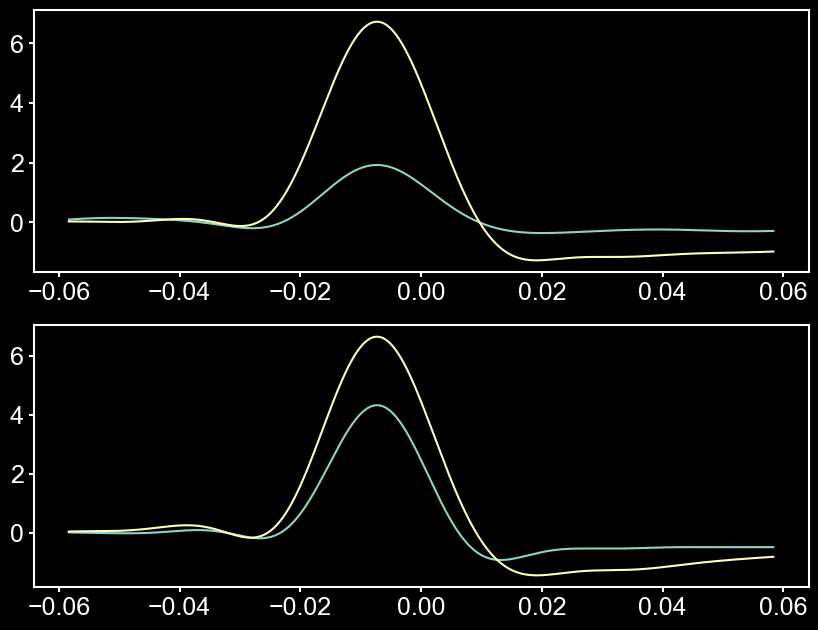

In [14]:
# plot cluster means as a check
fig, ax_list = plt.subplots(2,1)
ax_list = ax_list.ravel()

for ith, cluster_means in enumerate(cluster_means_all):
    for cluster_mean in cluster_means:
        ax_list[ith].plot(spike_t[ith], cluster_mean)

In [62]:
# # now we can try using stumpy to find that pattern in the overall time series
# import stumpy

# pat = cluster_means_all[0][0]
# sig = data['emg_filt'][0]
# matches = stumpy.match(
#     pat, 
#     sig,
#     max_distance=lambda D: max(np.mean(D) - 1 * np.std(D), np.min(D)),
#     normalize=False,
# )

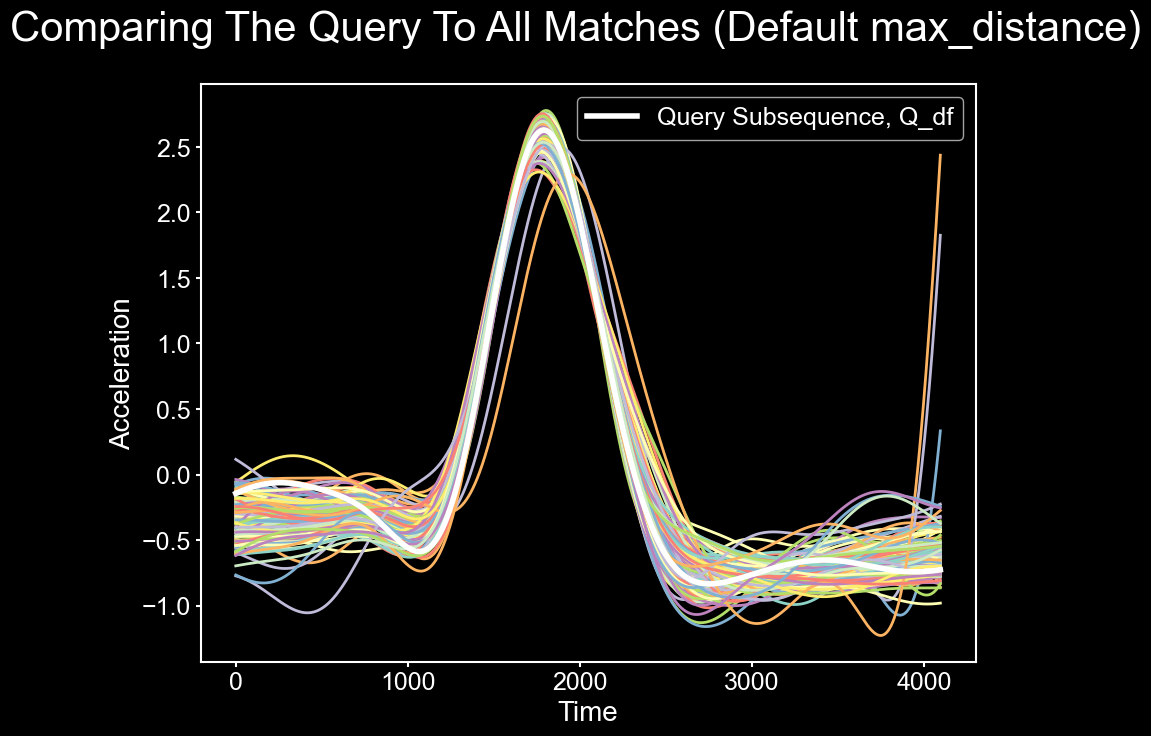

In [64]:
# pat_z_norm = stumpy.core.z_norm(pat)

# plt.suptitle('Comparing The Query To All Matches (Default max_distance)', fontsize='30')
# plt.xlabel('Time', fontsize ='20')
# plt.ylabel('Acceleration', fontsize='20')
# for match_distance, match_idx in matches:
#     match_z_norm = stumpy.core.z_norm(sig[match_idx:match_idx+pat.size])
#     plt.plot(match_z_norm, lw=2)
# plt.plot(pat_z_norm, lw=4, color="w", label="Query Subsequence, Q_df")
# plt.legend()
# plt.show()

In [66]:
# # look at where these matches are
# fig, ax = plt.subplots(figsize=(12, 2))

# match_idx = np.sort(matches[:,1].astype('int')) + 1791

# tmin = 0 #0
# tmax = 10  # 0.2  # 2
# tmask = (t >= tmin) & (t <= tmax)
# tmask_spikes = (t[match_idx] >= tmin) & (t[match_idx] <= tmax)

# ax.plot(t[tmask], sig[tmask])
# ax.plot(t[match_idx][tmask_spikes], sig[match_idx][tmask_spikes], 'x')

## Scratch

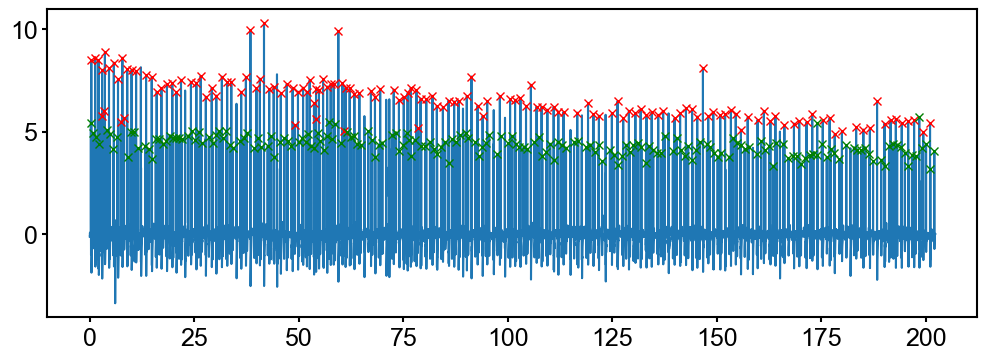

In [38]:
# just hard code these for now -- do second channel
spike_idx2 = spike_idx[1]
emg2 = emg_filt[1]
cluster_labels2 = cluster_labels[1]

spike_idx21 = spike_idx2[(cluster_labels2 == 1) | (cluster_labels2 == 2)]
spike_idx22 = spike_idx2[(cluster_labels2 == 0)]

fig, ax = plt.subplots(figsize=(12,4))

ax.plot(t, emg2)
ax.plot(t[spike_idx21], emg2[spike_idx21], 'rx')
ax.plot(t[spike_idx22], emg2[spike_idx22], 'gx')

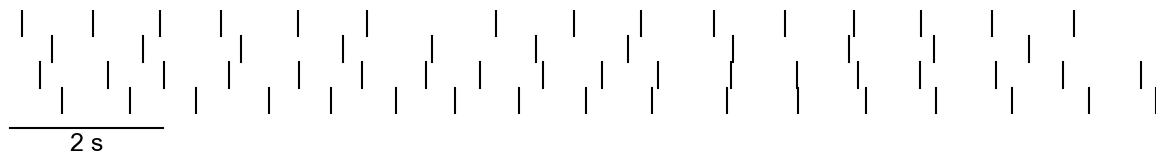

In [59]:
# plot raster
fig, ax = plt.subplots(figsize=(12, 2))

spike_times_all = [t[spike_idx11], t[spike_idx12], t[spike_idx21], t[spike_idx22]]
colors = ['k', 'k', 'k', 'k']
labels = ['unit0', 'unit1', 'unit2', 'unit3']
xlim = [100, 115]

ax = plot_spike_raster(spike_times_all, ax=ax, labels=labels, colors=colors, xlim=xlim)
# ax.set_xlabel('time (s)')

ax = my_adjust_axes(ax, keep_spines=['bottom'])
my_add_scalebar(ax, scalebar_bounds=[xlim[0], xlim[0]+2], units='s')

fig.tight_layout()
save_path = '/media/sam/SamData/Dropbox/Misc Presentations/Dickinson Group Meeting 10-23-2024/ifm_recordings/multi_channel_raster.png'
fig.savefig(save_path)

In [73]:
print('a')

a
